In [11]:
#Import necessary packages

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pymongo import MongoClient
import gensim

#Open MongoDB connection
client = MongoClient()

#Create database/start connection to database
db = client.news
articles = db.news

#Import created pipeline class
from nlp_pipeline import nlp_pipeline

In [3]:
#Query database
cursor = db.articles.find({}, {'_id':0, 'title': 1, 'is_opinion': 1, 'author': 1, 'link': 1, 'published_date': 1, 'summary': 1, 'published_date': 1})

#Create dictionary
article_headers = ['title', 'is_opinion', 'author', 'link', 'published_date', 'summary', 'published_date']

news_data = []

for article in cursor:
    title = article['title']
    is_opinion = article['is_opinion']
    author = article['author']
    link = article['link']
    published_date = article['published_date']
    summary = article['summary']
    published_date = article['published_date']
    news_dict = dict(zip(article_headers, [title, is_opinion, author, link, published_date, summary, published_date]))
    news_data.append(news_dict)

#Convert to DataFrame
news_df = pd.DataFrame(news_data)

#Drop duplications
pre_drop_total = len(news_df)
news_df.drop_duplicates(subset=['title'], inplace=True)
post_drop_total = len(news_df)
print(post_drop_total/pre_drop_total*100, '% of the total not dropped')

#Convert to list for model processing
full_news_docs = news_df['title'].to_list()

82.68757182728615 % of the total not dropped


In [4]:
#Pickle objects for easier future import
pickle.dump(news_df, open('news_df','wb')) #All docs for processing
pickle.dump(full_news_docs, open('full_news_docs','wb')) #All docs for processing

In [5]:
#Load in pickled objects
news_df = pickle.load(open('news_df','rb'))
full_news_docs = pickle.load(open('full_news_docs','rb'))

# Exploratory Data Analysis

In [6]:
#Average article title length

total_len = 0
for title in full_news_docs:
    title_len = len(title)
    total_len += title_len
    average_len = total_len/len(full_news_docs)
print('Average title length: ', average_len, 'characters')

Average title length:  68.22381614216222 characters


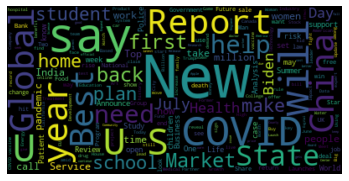

In [7]:
#Add wordcloud here for whole corpus
full_news_docs_wordcloud = ' '.join(full_news_docs) #Create corpus

# Display the generated image
wordcloud = WordCloud(stopwords = STOPWORDS).generate(full_news_docs_wordcloud)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Try Previous NMF Model with New Data Input

In [9]:
nlp_model_10 = nlp_pipeline(vectorizer=TfidfVectorizer(stop_words='english', max_df=.9, min_df = 10), tokenizer=None, cleaning_function=None, stemmer=None, lemm=WordNetLemmatizer(), model=NMF(n_components=12, random_state=42, max_iter=2000))

nlp_model_10.fit_transform(full_news_docs)
nlp_model_10.print_topics(10)

/Users/ANGar/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic #0: new york launch announces deal case city announce world return
Topic #1: market global billion reach report insight cagr forecast size growth
Topic #2: covid vaccine case study patient pandemic death test vaccination risk
Topic #3: say biden china police report trump right business president law
Topic #4: conversation news research page analysis information et recherche analyse france
Topic #5: best work place bryan booty shaking luke shot summer business
Topic #6: health care mental public worker service benefit insurance announces support
Topic #7: school student high public college state education parent summer teacher
Topic #8: july world day rate history today announces news week second
Topic #9: tax child credit payment family need know million card bank
Topic #10: stock price rise buy home news chart fall underperforms gas
Topic #11: year woman death man life pandemic record cancer time drug


# Updated Model with Word2Vec

In [12]:
#Load in Google's Word2Vec model
google_vec_file = '/Users/ANGar/Documents/Metis/Data Science and Machine Learning/Bootcamp Projects/Data_Engineeing_Project/GoogleNews-vectors-negative300 (1).bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [28]:
np.mean(np.array([model['meeting'], model['hat']]),axis=0)

array([-0.1574707 ,  0.03192139, -0.07141113, -0.08520508, -0.12133789,
       -0.10522461,  0.0949707 , -0.18945312,  0.21044922,  0.1274414 ,
        0.00152588,  0.00683594,  0.03285217, -0.08209229, -0.32958984,
        0.1111908 , -0.06469727,  0.15698242,  0.10009766, -0.12927246,
        0.24365234,  0.05212402,  0.00537109,  0.05096436,  0.05810547,
        0.03955078, -0.18408203,  0.00292969,  0.04663086, -0.05883789,
        0.00073242,  0.02050781,  0.16137695,  0.00039673,  0.15112305,
        0.11962891,  0.20532227,  0.12133789, -0.03057861,  0.02947998,
       -0.07348633, -0.01220703,  0.04754639,  0.01953125, -0.03955078,
       -0.10961914, -0.12896729, -0.29943848, -0.14221191,  0.23583984,
       -0.18676758,  0.11010742,  0.11132812, -0.0045166 , -0.06997681,
       -0.06335449, -0.05163574, -0.04589844,  0.1850586 , -0.04821777,
       -0.20117188,  0.0670166 , -0.17675781,  0.05053711, -0.08632565,
        0.10095215, -0.18017578,  0.13684082,  0.30078125,  0.02

In [24]:
#Pickle final model

pickle.dump(nlp_model_10, open('topic_model','wb')) 